# Milestone II

In [2]:
import pandas as pd
import numpy as np
import re
import pickle
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import nltk
from collections import Counter
from textstat import textstat
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK downloads
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("vader_lexicon")

# Ignore warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df = pd.read_csv('YoutubeCommentsDataSet.csv')
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


### Wyodrębnienie zbioru walidacyjnego

In [4]:
from sklearn.model_selection import train_test_split

# split the dataset into train (85%) and validation (15%)
df, validation_df = train_test_split(df, test_size=0.15, stratify=df['Sentiment'], random_state=42)

validation_df.to_csv("validation_set.csv", index=False)

# Preprocessing

Postanowiłyśmy z ramki danych usunąc wartości puste oraz występujące bezpośredni po sobie komentarze zduplikowane. 

W danych treninowych usunęłyśmy także stopwords z wyjątkiem negacji, które mogą mieć duży wpływ na przewidywany sentyment. Komentarze były także poddane lematyzacji. Usunięcie stopwords i lematyzację naniosłyśmy na dodatkową kolumnę Comment_preprocessed, gdyż potrzebna jest ona dalej w inżynierii cech.

In [5]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')  # Download WordNet corpus
nltk.download('omw-1.4')  # Optional: Better word sense
nltk.download('punkt')

wnl = WordNetLemmatizer()

def preprocess_text(text):
    # Get all stopwords but preserve negations
    all_stop_words = set()
    for lang in stopwords.fileids():
        all_stop_words.update(stopwords.words(lang))  

    # Stopwords, które nie są usuwane
    negation_words = {"no", "not", "never", "none", "nowhere", "nobody", "nothing", "neither", "nor", 
                    "isn't", "wasn't", "weren't", "doesn't", "don't", "didn't", "hasn't", "haven't", 
                    "hadn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", "couldn't", "mustn't"}

    # Remove stopwords except negations
    filtered_stop_words = all_stop_words - negation_words  

    words = word_tokenize(text.lower())  # Tokenize & lowercase
    filtered_words = [wnl.lemmatize(word) for word in words if word.isalnum() and word not in filtered_stop_words]  
    return ' '.join(filtered_words)  # Join words back into a sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
def preprocess_data(df):
    
    df = df.dropna()

    # dropping consecutive duplicates
    df = df.loc[df['Comment'] != df['Comment'].shift()].reset_index(drop=True)

    df['Comment_preprocessed'] = df['Comment'].apply(preprocess_text)
    df['Comment_preprocessed'] = df['Comment_preprocessed'].apply(lambda x: re.sub(r'\d+', '', x))

    return df

# Funkcje do obróbki danych, inżynieria cech

W kontekście naszych danych stwierdziłyśmy, że przydatne będą następujące cechy:
- Sentiment_Score_nltk (ciągły wskaźnik sentymentu komentarza o warotściach [-1, 1])
- Comment_length (długość komentarza)
- Starts_with_i (czy komentarz zaczyna się od I)
- Personal_Pronoun_count (liczba zaimków osobowych, takich jak he, she, i, etc.)
- Number_of_phrases (czyli podział komentarza według spójników "but", "and", "because")
- Avg_phrase_length (średnia długość frazy)
- Number_of_words (liczba słów)
- Avg_word_length (średnia długość słów)
- Unique_word_ratio (stosunek liczby unikalnych słów do wszystkich słów, im większa tym bardziej rozbudowane słownictwo)
- Readibility_Score (wskaźnik czytelności tekstu mierzony za pomocą Flesch Reading Ease)
- Negation_Count (ilość negacji w komentarzu, czyli słów, które wprowadzają zaprzeczenie np. "not","never","nobody","dont" itp.)
- Rare_Word_Count (Liczenie rzadkich słów na podstawie ich częstotliwości w całym zbiorze danych)


### Zmienna Sentiment_Score_nltk

In [7]:
# Funkcja do obliczania Sentiment Score za pomocą NLTK
sia = SentimentIntensityAnalyzer()
def sentiment_score(comment):
    return sia.polarity_scores(comment)['compound']

### Zmienna Personal_Pronun_Count

In [8]:
# Funkcja do liczenia liczby zaimków osobistych
personal_pronouns = {"i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves",
                     "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself",
                     "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
                     "theirs", "themselves"}

def count_personal_pronouns(comment):
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in personal_pronouns)

### Zmienne Number_of_phrases, Number_of_words, Avg_phrase_length, Avg_word_length, Unique_word_ratio

In [9]:
# Funkcja do analizy złożoności zdań (np. liczba fraz, słów)
connectors = ["and", "but", "so", "because", "which", "that", "then", "if", "or"]
def sentence_complexity(comment):
    words = word_tokenize(comment)
    phrases = re.split(r'\b(?:' + '|'.join(connectors) + r')\b', comment)

    num_words = len(words)
    num_phrases = len(phrases)

    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    avg_phrase_length = num_words / num_phrases if num_phrases > 0 else 0
    unique_word_ratio = len(set(words)) / num_words if num_words > 0 else 0

    return {
        "Number_of_phrases": num_phrases,
        "Number_of_words": num_words,
        "Avg_phrase_length": avg_phrase_length,
        "Avg_word_length": avg_word_length,
        "Unique_word_ratio": unique_word_ratio
    }


### Zmienna Readability_Score

In [10]:
# Funkcja do obliczania readability score
def readability_score(comment):
    return textstat.flesch_reading_ease(comment)

### Zmienna Negation_Count

In [11]:
# Funkcja do liczenia negacji
def negation_count(comment):
    negations = {"not", "never", "no", "none", "cannot", "nothing","dont","nah",'wont','cant','doesnt','shouldnt',"shouldn't","doesn't"
                 "don't","won't","wouldn't", "can't","nobody",'neither','nope',"ain't","nowhere",'wouldnt'}
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in negations)

### Zmienna Rare_Word_Count

In [12]:
# Funkcja do liczenia rzadkich słów
def rare_word_count(comment, all_words):
    words = word_tokenize(comment.lower())
    rare_words = [word for word in words if all_words[word] < 10]  # Możemy dostosować próg (tutaj <10)
    return len(rare_words)

Przygotowujemy cechy:

In [13]:
def prepare_features(df):
    # Ensure 'Comment' column is string and handle NaNs
    df['Comment'] = df['Comment'].fillna('').astype(str)

    df['Sentiment_Score_nltk'] = df['Comment'].apply(sentiment_score)
    df['Starts_with_i'] = df['Comment'].str.startswith("i")
    df['Comment_Length'] = df['Comment'].str.len()

    df["Personal_Pronoun_count"] = df["Comment"].apply(count_personal_pronouns)
    df["Readability_Score"] = df["Comment"].apply(readability_score)
    df["Negation_Count"] = df["Comment"].apply(negation_count)

    df_complexity = df["Comment"].apply(lambda x: sentence_complexity(x))
    df_complexity = pd.DataFrame(df_complexity.tolist(), index=df.index)
    df = pd.concat([df, df_complexity], axis=1)

    # Rare word count
    all_words = Counter(' '.join(df['Comment']).lower().split())
    df['Rare_Word_Count'] = df['Comment'].apply(lambda x: rare_word_count(x, all_words))

    return df


# Pipeline

In [16]:
df = preprocess_data(df)
validation_df=preprocess_data(validation_df)

## Macierz korelacji

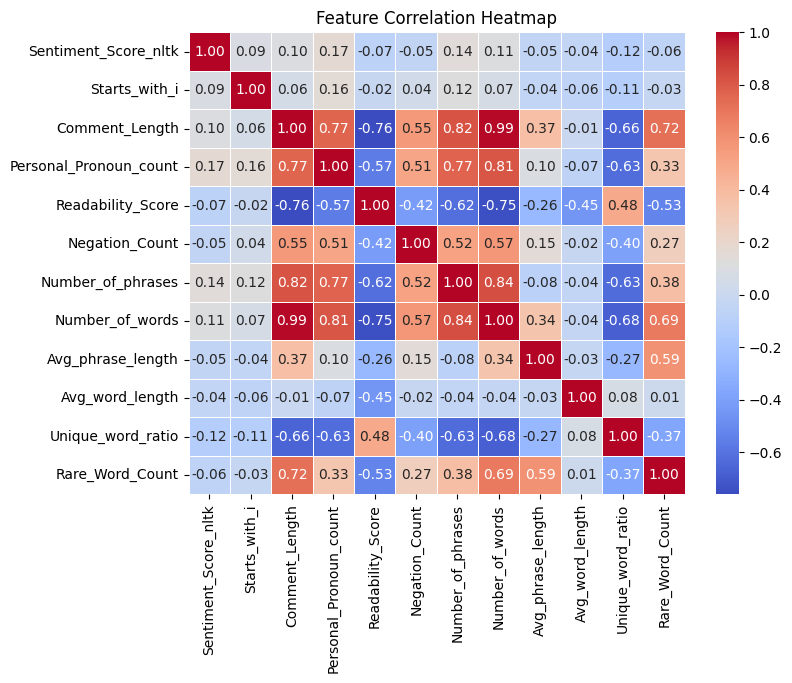

In [20]:
df_matrix = prepare_features(df)
corr_matrix = df_matrix.drop(columns=["Comment", "Sentiment","Comment_preprocessed"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Widać, że zmienne Number_of_words, Number_of_phrases i Comment_Length są silnie skorelowane, dlatego pod uwagę weźniemy tylko cechę Comment_Length.

In [40]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
    
# Podział na zbiór treningowy i walidacyjny
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

X_train = df_train.drop(columns=['Sentiment'])
y_train = df_train['Sentiment']
X_test = df_test.drop(columns=['Sentiment'])
y_test = df_test['Sentiment']
X_val = validation_df.drop(columns=['Sentiment'])
y_val = validation_df['Sentiment']

pipe = Pipeline([
    ('feature_eng', FunctionTransformer(prepare_features, validate=False)),
    ('select_text', FunctionTransformer(lambda x: x['Comment_preprocessed'], validate=False)),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression())
])

# Fit and evaluate
pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")


Test accuracy: 0.7050


# Test podstawowych modeli

Z podstawowych modeli, k†óre testowałyśmy była regresja liniowa. Pomimo dobrych wyników na zbiorze treningowym, model Random Forest przewiduje bardzo źle, co wskazuje na jego przetrenowanie.

In [41]:
def full_preprocessing_pipeline(df):
    df = preprocess_data(df)        # Text cleaning, stopword removal, lemmatization
    df = prepare_features(df)       # Feature engineering
    return df

In [43]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K Nearest Neighbours': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'LightGBM': LGBMClassifier()
}

numeric_columns = [
    'Sentiment_Score_nltk',
    'Starts_with_i',
    'Comment_Length',
    'Personal_Pronoun_count',
    'Readability_Score',
    'Negation_Count',
    'Avg_word_length',
    'Avg_phrase_length',
    'Unique_word_ratio',
    'Rare_Word_Count'
]

text_column = 'Comment_preprocessed'

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), text_column),
        ('num', StandardScaler(), numeric_columns)
    ]
)

for name, model in models.items():
    print(f"\n=== {name} ===")

    pipe = ImbPipeline([
        ('preprocessing', FunctionTransformer(full_preprocessing_pipeline, validate=False)),
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=0)),
        ('classifier', model)
    ])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_val_pred = pipe.predict(X_val)

    print("\n-- Train Data --")
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(classification_report(y_train, y_train_pred))

    print("\n-- Validation Data --")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    print(classification_report(y_val, y_val_pred))



=== Logistic Regression ===


KeyboardInterrupt: 

Testowanie modeli z określonymi hiperparametrami:

In [ ]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', C=1.0, class_weight='balanced'),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        class_weight='balanced', random_state=42
    ),
    
    'K Nearest Neighbours': KNeighborsClassifier(
        n_neighbors=5, weights='distance', metric='minkowski', p=2
    ),
    
    'Support Vector Machine': SVC(
        kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced'
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5, class_weight='balanced', random_state=42
    ),
    
    'LightGBM': LGBMClassifier(
        n_estimators=100, max_depth=10, learning_rate=0.1, class_weight='balanced', random_state=42
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=2,  # scale_pos_weight podbija wagę klasy mniejszościowej
        subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss', use_label_encoder=False, random_state=42
    )
}

numeric_columns = [
    'Sentiment_Score_nltk',
    'Starts_with_i',
    'Comment_Length',
    'Personal_Pronoun_count',
    'Readability_Score',
    'Negation_Count',
    'Avg_word_length',
    'Avg_phrase_length',
    'Unique_word_ratio',
    'Rare_Word_Count'
]

text_column = 'Comment_preprocessed'

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), text_column),
        ('num', StandardScaler(), numeric_columns)
    ]
)

for name, model in models.items():
    print(f"\n=== {name} ===")

    pipe = ImbPipeline([
        ('preprocessing', FunctionTransformer(full_preprocessing_pipeline, validate=False)),
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=0)),
        ('classifier', model)
    ])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_val_pred = pipe.predict(X_val)

    print("\n-- Train Data --")
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(classification_report(y_train, y_train_pred))

    print("\n-- Validation Data --")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    print(classification_report(y_val, y_val_pred))




=== Logistic Regression ===

-- Train Data --
Accuracy: 0.8770
              precision    recall  f1-score   support

    negative       0.74      0.93      0.82      1372
     neutral       0.80      0.84      0.82      2746
    positive       0.95      0.88      0.91      6805

    accuracy                           0.88     10923
   macro avg       0.83      0.89      0.85     10923
weighted avg       0.89      0.88      0.88     10923


=== Random Forest ===

-- Train Data --
Accuracy: 0.7465
              precision    recall  f1-score   support

    negative       0.53      0.64      0.58      1372
     neutral       0.60      0.62      0.61      2746
    positive       0.87      0.82      0.84      6805

    accuracy                           0.75     10923
   macro avg       0.66      0.69      0.68     10923
weighted avg       0.76      0.75      0.75     10923


=== K Nearest Neighbours ===


KeyboardInterrupt: 